In [1]:
import pandas as pd
from statsmodels.stats.weightstats import ttest_ind

df = pd.read_parquet('data/hh.parquet')
services = pd.read_parquet('data/services.parquet')
food = pd.read_parquet('data/food.parquet')
health = pd.read_parquet('data/health.parquet')
edu = pd.read_parquet('data/education.parquet')

# eligibility = hh with enrolments, children of schoolgoing age
services = services[services['is_hhmem_edu'] == 1]
df = df[df['n_schoolchildren'] > 0]
ix = df.index.intersection(services.index)
df, services = df.loc[ix], services.loc[ix]
df['treat'] = services['received_fee_waiver'] == 1

ix = df.index
for i in [food, health, edu]:
    ix = i.index.intersection(ix)
df = df.loc[ix]

df['FOOD'] = food.loc[df.index].sum(axis=1)
df['EDUCATION'] = edu.loc[df.index].sum(axis=1)
df['HEALTH'] = health.loc[df.index].sum(axis=1)
df.head()

,sector,nss_region,multiplier,family_size,n_children,n_schoolchildren,n_elderly,n_school_meals,employed_annual,nco_2015,...,hoh_religion,caste,energy_source_cooking,energy_source_lighting,rationcard_type,has_benefited_from_pmgky,treat,FOOD,EDUCATION,HEALTH
hhid,,,,,,,,,,,,,,,,,,,,,
22300305,urban,341,28599,8,2,2,2,0.0,yes,112.0,...,Jainism,other backward class (OBC),LPG,electricity (incl. generated by solar or wind ...,Above Poverty Line (APL),no,False,27221.000000,175.000000,241.666667
22300313,urban,341,28599,3,1,1,0,0.0,yes,143.0,...,Hinduism,other backward class (OBC),LPG,electricity (incl. generated by solar or wind ...,Above Poverty Line (APL),no,False,15562.666667,233.333333,4000.000000
22301301,urban,341,16099,4,1,2,0,22.0,yes,112.0,...,Hinduism,other backward class (OBC),LPG,electricity (incl. generated by solar or wind ...,Below Poverty Line (BPL),no,False,9921.000000,225.000000,70.833333
22301304,urban,341,16099,4,1,1,0,0.0,yes,932.0,...,Hinduism,other backward class (OBC),LPG,electricity (incl. generated by solar or wind ...,Below Poverty Line (BPL),no,False,15111.333333,166.666667,166.666667
22301307,urban,341,16099,6,1,1,1,0.0,yes,931.0,...,Hinduism,other backward class (OBC),LPG,electricity (incl. generated by solar or wind ...,Below Poverty Line (BPL),yes,False,14048.666667,258.333333,112.500000


In [30]:
df['treat'] = services.loc[df.index, 'received_fee_waiver'] == 1
d_fee = df.groupby(['sector', 'treat']).apply(lambda x: (x[['FOOD', 'EDUCATION', 'HEALTH']] * x['multiplier'].values.reshape(-1, 1)).sum(axis=0) / x['multiplier'].sum())
d_fee

FOOD    EDUCATION      HEALTH
sector treat                                       
rural  False  10075.087852   881.368804  336.768279
       True    9675.666303   645.049532  305.767440
urban  False  12342.987679  1309.737457  411.746614
       True   10934.694227   982.678976  365.345256

In [31]:
df['treat'] = df['n_school_meals'] > 0
d_meals = df.groupby(['sector', 'treat']).apply(lambda x: (x[['FOOD', 'EDUCATION', 'HEALTH']] * x['multiplier'].values.reshape(-1, 1)).sum(axis=0) / x['multiplier'].sum())
d_meals

FOOD    EDUCATION      HEALTH
sector treat                                       
rural  False  10209.720504  1143.067863  357.716601
       True    9810.489783   539.586040  305.548850
urban  False  12502.633228  1413.043730  423.075536
       True   11019.912911   697.488010  340.207103

<Axes: ylabel='sector-treat'>

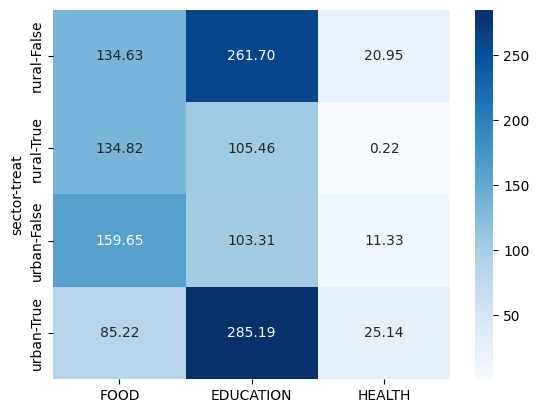

In [37]:
sns.heatmap((d_fee - d_meals).abs(), annot=True, cmap='Blues', fmt=".2f")

In [41]:
edf = edu.loc[df.index]

In [44]:
edf['sector'] = df['sector']
edf['multiplier'] = df['multiplier']
edf['treat'] = services.loc[edf.index, 'received_fee_waiver'] == 1
edf.head()

,books_1st,books_2nd,stationery,fees,coaching,edu_other,sector,treat,multiplier
hhid,,,,,,,,,
22300305,NaN,NaN,150.000000,25.000000,NaN,NaN,urban,False,28599
22300313,125.0,NaN,41.666667,NaN,NaN,66.666667,urban,False,28599
22301301,NaN,NaN,41.666667,183.333333,NaN,NaN,urban,False,16099
22301304,NaN,NaN,41.666667,125.000000,NaN,NaN,urban,False,16099
22301307,NaN,NaN,133.333333,125.000000,NaN,NaN,urban,False,16099


In [47]:
cols = edf.drop(['treat', 'sector', 'multiplier'], axis=1).columns
edf.groupby(['sector', 'treat']).apply(lambda x: (x[cols] * x['multiplier'].values.reshape(-1, 1)).sum(axis=0) / x['multiplier'].sum())

books_1st  books_2nd  stationery        fees    coaching  \
sector treat                                                              
rural  False  160.186284   5.139489  104.646124  421.806830  174.792242   
       True   111.194684   4.702096  103.025044  239.758329  170.737919   
urban  False  261.407854   7.589263  130.153380  624.436244  255.419029   
       True   166.702851   5.823154  119.800581  416.546826  250.740906   

              edu_other  
sector treat             
rural  False  14.797835  
       True   15.631460  
urban  False  30.731687  
       True   23.064658

In [49]:
fdf = food.loc[df.index]
fdf['sector'] = df['sector']
fdf['multiplier'] = df['multiplier']
fdf['treat'] = services.loc[fdf.index, 'received_fee_waiver'] == 1
fdf.head()

,cereals,pulses,sugar_salt,dairy,veg,fruits,meat,oil,spice,bev,cooked,processed,sector,multiplier,treat
hhid,,,,,,,,,,,,,,,
22300305,2335.0,1075.0,320.0,3640.000000,2747.333333,1885.000000,4983.333333,3033.333333,2357.333333,901.333333,1646.666667,2296.666667,urban,28599,False
22300313,1455.0,689.0,163.0,1906.666667,1495.000000,1863.333333,2808.000000,1161.333333,897.000000,936.000000,1083.333333,1105.000000,urban,28599,False
22301301,1515.0,458.0,122.0,888.333333,1105.000000,1040.000000,1863.333333,693.333333,641.333333,641.333333,173.333333,780.000000,urban,16099,False
22301304,1323.0,473.0,103.0,1516.666667,1538.333333,2210.000000,2513.333333,780.000000,832.000000,658.666667,1300.000000,1863.333333,urban,16099,False
22301307,2316.0,830.0,130.0,1646.666667,1239.333333,736.666667,2080.000000,1040.000000,858.000000,875.333333,1126.666667,1170.000000,urban,16099,False


In [50]:
cols = fdf.drop(['treat', 'sector', 'multiplier'], axis=1).columns
fdf.groupby(['sector', 'treat']).apply(lambda x: (x[cols] * x['multiplier'].values.reshape(-1, 1)).sum(axis=0) / x['multiplier'].sum())

cereals      pulses  sugar_salt        dairy          veg  \
sector treat                                                                  
rural  False  1118.777011  441.376599  189.691010  1846.261730  1287.201500   
       True   1094.388616  388.881301  203.435254  1816.543200  1217.759447   
urban  False  1273.099912  463.919554  191.773704  2476.517071  1329.616730   
       True   1167.923986  421.407509  194.757671  2036.261587  1272.884743   

                  fruits         meat         oil       spice         bev  \
sector treat                                                                
rural  False  591.999022  1071.392982  605.631206  677.888661  508.040247   
       True   504.691574   938.545433  602.352100  679.734884  467.763055   
urban  False  845.930402  1154.270304  602.116793  728.461825  828.258144   
       True   668.856466  1061.728289  632.480192  696.126429  640.068887   

                   cooked    processed  
sector treat                            
rural  False  1021.266984   715.560899  
       True   1095.444121   666.127316  
urban  False  1394.210340  1054.812900  
       True   1258.482574   883.715894

In [52]:
hdf = health.loc[df.index]
hdf['sector'] = df['sector']
hdf['multiplier'] = df['multiplier']
hdf['treat'] = services.loc[hdf.index, 'received_fee_waiver'] == 1
hdf.head()

item_code,410,411,412,413,414,420,421,422,423,424,sector,multiplier,treat
hhid,,,,,,,,,,,,,
22300305,NaN,NaN,NaN,NaN,NaN,208.333333,NaN,33.333333,NaN,NaN,urban,28599,False
22300313,1250.0,375.0,2083.333333,208.333333,NaN,66.666667,NaN,16.666667,NaN,NaN,urban,28599,False
22301301,NaN,NaN,NaN,NaN,NaN,54.166667,NaN,16.666667,NaN,NaN,urban,16099,False
22301304,NaN,NaN,NaN,NaN,NaN,150.000000,NaN,16.666667,NaN,NaN,urban,16099,False
22301307,NaN,NaN,NaN,NaN,NaN,91.666667,NaN,20.833333,NaN,NaN,urban,16099,False


In [53]:
cols = hdf.drop(['treat', 'sector', 'multiplier'], axis=1).columns
hdf.groupby(['sector', 'treat']).apply(lambda x: (x[cols] * x['multiplier'].values.reshape(-1, 1)).sum(axis=0) / x['multiplier'].sum())

item_code           410        411        412        413        414  \
sector treat                                                          
rural  False  92.132199  45.121226  44.596676  60.092015  19.617541   
       True   84.176089  41.893680  40.146079  50.934320  18.454223   
urban  False  99.501777  56.278132  59.366645  78.492185  24.045225   
       True   94.253443  51.537699  46.926758  64.292561  22.214667   

item_code           420       421        422       423       424  
sector treat                                                      
rural  False  57.525076  6.322216   9.214368  0.368441  1.778523  
       True   53.515537  5.924399   8.682221  0.507750  1.533143  
urban  False  69.262107  8.093865  13.960610  0.590204  2.155862  
       True   65.307881  6.363039  12.278787  0.512178  1.658243

---

In [54]:
df['treat'] = df['n_school_meals'] > 0
d_meals = df.groupby(['sector', 'treat']).apply(lambda x: (x[['FOOD', 'EDUCATION', 'HEALTH']] * x['multiplier'].values.reshape(-1, 1)).sum(axis=0) / x['multiplier'].sum())
d_meals

FOOD    EDUCATION      HEALTH
sector treat                                       
rural  False  10209.720504  1143.067863  357.716601
       True    9810.489783   539.586040  305.548850
urban  False  12502.633228  1413.043730  423.075536
       True   11019.912911   697.488010  340.207103

In [55]:
edf['sector'] = df['sector']
edf['multiplier'] = df['multiplier']
edf['treat'] = df['treat']
edf.head()

,books_1st,books_2nd,stationery,fees,coaching,edu_other,sector,treat,multiplier
hhid,,,,,,,,,
22300305,NaN,NaN,150.000000,25.000000,NaN,NaN,urban,False,28599
22300313,125.0,NaN,41.666667,NaN,NaN,66.666667,urban,False,28599
22301301,NaN,NaN,41.666667,183.333333,NaN,NaN,urban,True,16099
22301304,NaN,NaN,41.666667,125.000000,NaN,NaN,urban,False,16099
22301307,NaN,NaN,133.333333,125.000000,NaN,NaN,urban,False,16099


In [56]:
cols = edf.drop(['treat', 'sector', 'multiplier'], axis=1).columns
edf.groupby(['sector', 'treat']).apply(lambda x: (x[cols] * x['multiplier'].values.reshape(-1, 1)).sum(axis=0) / x['multiplier'].sum())

books_1st  books_2nd  stationery        fees    coaching  \
sector treat                                                              
rural  False  215.221532   6.319366  122.363473  620.515805  159.500881   
       True    88.535096   3.799205   86.100487  161.456034  189.056219   
urban  False  285.952726   8.485909  136.984270  687.826838  260.797140   
       True   108.845190   2.723029   94.376097  245.742913  228.700621   

              edu_other  
sector treat             
rural  False  19.146807  
       True   10.638999  
urban  False  32.996846  
       True   17.100159

In [57]:
fdf = food.loc[df.index]
fdf['sector'] = df['sector']
fdf['multiplier'] = df['multiplier']
fdf['treat'] = df['treat']
fdf.head()

,cereals,pulses,sugar_salt,dairy,veg,fruits,meat,oil,spice,bev,cooked,processed,sector,multiplier,treat
hhid,,,,,,,,,,,,,,,
22300305,2335.0,1075.0,320.0,3640.000000,2747.333333,1885.000000,4983.333333,3033.333333,2357.333333,901.333333,1646.666667,2296.666667,urban,28599,False
22300313,1455.0,689.0,163.0,1906.666667,1495.000000,1863.333333,2808.000000,1161.333333,897.000000,936.000000,1083.333333,1105.000000,urban,28599,False
22301301,1515.0,458.0,122.0,888.333333,1105.000000,1040.000000,1863.333333,693.333333,641.333333,641.333333,173.333333,780.000000,urban,16099,True
22301304,1323.0,473.0,103.0,1516.666667,1538.333333,2210.000000,2513.333333,780.000000,832.000000,658.666667,1300.000000,1863.333333,urban,16099,False
22301307,2316.0,830.0,130.0,1646.666667,1239.333333,736.666667,2080.000000,1040.000000,858.000000,875.333333,1126.666667,1170.000000,urban,16099,False


In [58]:
cols = fdf.drop(['treat', 'sector', 'multiplier'], axis=1).columns
fdf.groupby(['sector', 'treat']).apply(lambda x: (x[cols] * x['multiplier'].values.reshape(-1, 1)).sum(axis=0) / x['multiplier'].sum())

cereals      pulses  sugar_salt        dairy          veg  \
sector treat                                                                  
rural  False  1118.598726  452.446879  207.032319  2192.071188  1305.878980   
       True   1111.166839  413.341234  176.436901  1484.899667  1246.011532   
urban  False  1299.190184  474.130329  196.924653  2619.477450  1351.818399   
       True   1109.049537  399.152643  169.300102  1634.409217  1203.697046   

                  fruits         meat         oil       spice         bev  \
sector treat                                                                
rural  False  629.967101   982.571931  611.098073  694.828789  549.981619   
       True   525.472888  1119.328061  599.020961  661.241593  452.496395   
urban  False  869.147192  1104.046063  613.699715  738.225091  845.163762   
       True   665.096168  1346.911153  561.455220  670.004146  671.845509   

                   cooked    processed  
sector treat                            
rural  False   712.302752   752.942148  
       True   1359.341932   661.731781  
urban  False  1304.469881  1086.340509  
       True   1750.788342   838.203828

In [59]:
hdf = health.loc[df.index]
hdf['sector'] = df['sector']
hdf['multiplier'] = df['multiplier']
hdf['treat'] = df['treat']
hdf.head()

item_code,410,411,412,413,414,420,421,422,423,424,sector,multiplier,treat
hhid,,,,,,,,,,,,,
22300305,NaN,NaN,NaN,NaN,NaN,208.333333,NaN,33.333333,NaN,NaN,urban,28599,False
22300313,1250.0,375.0,2083.333333,208.333333,NaN,66.666667,NaN,16.666667,NaN,NaN,urban,28599,False
22301301,NaN,NaN,NaN,NaN,NaN,54.166667,NaN,16.666667,NaN,NaN,urban,16099,True
22301304,NaN,NaN,NaN,NaN,NaN,150.000000,NaN,16.666667,NaN,NaN,urban,16099,False
22301307,NaN,NaN,NaN,NaN,NaN,91.666667,NaN,20.833333,NaN,NaN,urban,16099,False


In [60]:
cols = hdf.drop(['treat', 'sector', 'multiplier'], axis=1).columns
hdf.groupby(['sector', 'treat']).apply(lambda x: (x[cols] * x['multiplier'].values.reshape(-1, 1)).sum(axis=0) / x['multiplier'].sum())

item_code            410        411        412        413        414  \
sector treat                                                           
rural  False   95.792518  47.951241  46.695065  65.310805  21.998652   
       True    85.865944  41.210498  41.039653  51.856106  16.823060   
urban  False  100.791054  58.364128  60.838777  80.828293  24.902215   
       True    91.373787  44.693409  47.394327  61.806736  19.334701   

item_code           420       421        422       423       424  
sector treat                                                      
rural  False  60.610728  7.083264   9.728186  0.453388  2.092752  
       True   53.104403  5.420741   8.521538  0.326512  1.380395  
urban  False  71.845674  8.281219  14.364464  0.647429  2.212284  
       True   55.714371  6.508549  11.398799  0.294117  1.688306